## packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
import scipy.io as sio
from datetime import datetime
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)
plt.rc('figure', figsize=(10,10))


In [2]:
import matplotlib.collections as collections
from numpy.fft import fft, ifft, fftshift, fftfreq
import pywt
from scipy import signal
import matplotlib as mpl
from scipy.interpolate import griddata

from sklearn.linear_model import LinearRegression

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

## funciones

In [3]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

In [4]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [5]:
def earth_to_uv(dfe, dfn, a): 
    "This takes 2 dataframes of east and north coordinates respectively and the regresion coeficient and transforms them to the direction of the coeficient"
    alpha = np.arctan(a) #Ángulo
    t, b = dfe.shape 
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]]) #Matriz de transfomación
    columns = dfe.columns
    u = np.zeros((0,t)) #Inicialización de variables
    v = np.zeros((0,t)) #Inicialización de variables
    for i in columns: #Iteración sobre las columnas de los dataframes
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]]) # Matriz de coordenadas east-north
        ui, vi = np.tensordot(M, bin_, 1) #Multiplicación matricial
        u = np.concatenate((u, ui), axis=0) #Unión de los resultados de u
        v = np.concatenate((v, vi), axis=0)#Unión de los resultados de v
    return u, v

In [6]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [7]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

In [8]:
def spectrum3(h, dt=1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)

In [9]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [10]:
def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

In [11]:
import math

def haversine(lat1, lon1, lat2, lon2):
    rad = math.pi/180
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    R = 6372.795477598 # km radio de la tierra
    a = (math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    dist = 2*R*math.asin(math.sqrt(a))
    return dist

# Importar y arreglar datos

In [12]:
DC_CTD = xr.open_dataset("data//DC_CTD")
NM_CTD = xr.open_dataset("data//NM_CTD")
ML_CTD = xr.open_dataset("data//ML_CTD")
PC_CTD = xr.open_dataset("data//PC_CTD")

In [13]:
DC_CTD['v'] = DC_CTD['__xarray_dataarray_variable__']
DC_CTD = DC_CTD.drop(['__xarray_dataarray_variable__'])

NM_CTD['v'] = NM_CTD['__xarray_dataarray_variable__']
NM_CTD = NM_CTD.drop(['__xarray_dataarray_variable__'])

ML_CTD['v'] = ML_CTD['__xarray_dataarray_variable__']
ML_CTD = ML_CTD.drop(['__xarray_dataarray_variable__'])

PC_CTD['v'] = PC_CTD['__xarray_dataarray_variable__']
PC_CTD = PC_CTD.drop(['__xarray_dataarray_variable__'])

In [14]:
z_dc1 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=1)
z_dc2 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=2)
z_dc2.coords['sensor'] = 2
z_dc3 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=3)
z_dc3.coords['sensor'] = 3
z_dc4 = DC_CTD.sel(variables='Depth', sensor=1) - DC_CTD.sel(variables='Depth', sensor=4)
z_dc4.coords['sensor'] = 4
z_dc = xr.concat([z_dc1, z_dc2, z_dc3, z_dc4], "sensor")
z_dc = z_dc.assign_coords(variables=("Depth2"))
DC_CTD = xr.concat([DC_CTD, z_dc], dim="variables")

In [15]:
z_nm1 = NM_CTD.sel(variables='Depth', sensor=1) - NM_CTD.sel(variables='Depth', sensor=1)
z_nm2 = NM_CTD.sel(variables='Depth', sensor=1) - NM_CTD.sel(variables='Depth', sensor=2)
z_nm2.coords['sensor'] = 2
z_nm3 = NM_CTD.sel(variables='Depth', sensor=1) - NM_CTD.sel(variables='Depth', sensor=3)
z_nm3.coords['sensor'] = 3
z_nm = xr.concat([z_nm1, z_nm2, z_nm3], "sensor")
z_nm = z_nm.assign_coords(variables=("Depth2"))
NM_CTD = xr.concat([NM_CTD, z_nm], dim="variables")

In [16]:
z_ml1 = ML_CTD.sel(variables='Depth', sensor=1) - ML_CTD.sel(variables='Depth', sensor=1)
z_ml2 = ML_CTD.sel(variables='Depth', sensor=1) - ML_CTD.sel(variables='Depth', sensor=2)
z_ml2.coords['sensor'] = 2
z_ml = xr.concat([z_ml1, z_ml2], "sensor")
z_ml = z_ml.assign_coords(variables=("Depth2"))
ML_CTD = xr.concat([ML_CTD, z_ml], dim="variables")

In [17]:
z_pc1 = PC_CTD.sel(variables='Depth', sensor=1) - PC_CTD.sel(variables='Depth', sensor=1)
z_pc = xr.concat([z_pc1], "sensor")
z_pc = z_pc.assign_coords(variables=("Depth2"))
PC_CTD = xr.concat([PC_CTD, z_pc], dim="variables")

In [18]:
#Viento
df2 = pd.read_table('C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120301.dat', sep=",", header=[1, 2, 3])
df2 = pd.DataFrame(df2.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df2 = df2.set_index('TIMESTAMP')
df3 = pd.read_table('C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120419.dat', sep=",", header=[1, 2, 3])
df3 = pd.DataFrame(df3.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df3 = df3.set_index('TIMESTAMP')
result = pd.concat([df2, df3], ignore_index=False, sort=False)
result.index = pd.to_datetime(result.index)
w = result

In [19]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

uw, vw = earth_to_uv(east_w, north_w, 0.79970532)

dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index

In [20]:
#Leer datos caudal
Q = pd.read_csv("data\\febmar2012.csv")
lista_nombres= ["nan1", "fecha", "nan2", "sensor", 
                "caudal", "A"]
Q.columns=lista_nombres
Q = Q.drop(columns=['nan1', 'nan2', 'sensor', 'A']).reset_index()
Q = Q.drop(columns=['level_0', 'level_1'])
Q["fecha"] = pd.to_datetime(Q["fecha"].values)

In [21]:
#Importar caudal de pescadero cada 15 min en GMT
# https://nwis.waterservices.usgs.gov/nwis/iv/?sites=11162500&parameterCd=00060&startDT=2011-07-07T00:00:00.000-07:00&endDT=2012-07-07T23:59:59.999-07:00&siteStatus=all&format=rdb
Q = pd.read_csv("data\\caudal2012.csv", sep=';')
Q = Q.drop(['5s', '15s', '14n', 'Unnamed: 6'], axis=1)
Q['index'] = pd.to_datetime(Q['20d'] + ' ' + Q['6s'], format='%d-%m-%Y %H:%M')
Q = Q.set_index('index')
Q = Q.drop(['20d', '6s'], axis=1)

In [22]:
#Importar nivel de agua cada 6 min en hora local
snfco = pd.read_csv("data/CO-OPS_9414290_met.csv")
snfco = snfco.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
snfco['index'] = pd.to_datetime(snfco['Date'] + ' ' + snfco['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
snfco = snfco.set_index('index')
snfco = snfco.drop(['Date', 'Time (LST/LDT)'], axis=1)

mnty = pd.read_csv("data/CO-OPS_9413450_met.csv")
mnty = mnty.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
mnty['index'] = pd.to_datetime(mnty['Date'] + ' ' + mnty['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
mnty = mnty.set_index('index')
mnty = mnty.drop(['Date', 'Time (LST/LDT)'], axis=1)

In [23]:
#Importar datos boya 46012 (Half moon bay)
# https://www.ndbc.noaa.gov/station_history.php?station=46012
hmoon = pd.read_csv("data/46012h2012.csv", sep=';', header=0)
hmoon = hmoon.drop(['PRES','TIDE', 'ATMP', 'WTMP','DEWP', 'VIS', 'WDI', 'R WSP', 'D GST'], axis=1)
hmoon = hmoon.drop([0], axis=0)
hmoon['index'] = pd.to_datetime(hmoon['#YY'] + '-' + hmoon['MM'] + '-' + hmoon['DD'] + ' ' + hmoon['hh'] + ':' + hmoon['mm'], format='%Y-%m-%d %H:%M')
hmoon = hmoon.set_index('index')
hmoon = hmoon.drop(['#YY', 'MM', 'DD', 'hh', 'mm'], axis=1)
hmoon['WVHT'] = hmoon['WVHT'].astype('float64')
hmoon['DPD'] = hmoon['DPD'].astype('float64')
hmoon['APD'] = hmoon['APD'].astype('float64')
hmoon['MWD'] = hmoon['MWD'].astype('float64')
hmoon = hmoon.drop([datetime(2012,2,14,19,50,0), datetime(2012,2,22,11,50,0), datetime(2012,2,23,11,50,0)], axis=0)
# WVHT: Significant wave height
# DPD: Dominant wave period (seconds) is the period with the maximum wave energy.
# APD: Average wave period (seconds) of all waves during the 20-minute period. 

In [24]:
#Importar datos de backscatter
# bks_drp = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp.npy")
# bks_drp1 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp1.npy")
# bks_drp2 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp2.npy")
# bks_drp3 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp3.npy")
# bks_drp4 = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp4.npy")
# bks_drp1 = np.load("data/bks_drp1.npy")
# bks_drp2 = np.load("data/bks_drp2.npy")
# bks_drp3 = np.load("data/bks_drp3.npy")
# bks_drp4 = np.load("data/bks_drp4.npy")

## Perfiles

In [25]:
p1 = pd.read_csv("data/perfil1.csv", sep=';')
p1 = p1.drop(['Conductividad', 'Presión', 'Turbidez','Conduct Especifica', 'Density anomaly', 'C'], axis=1)

## viento

In [26]:
rho_air = 1.2
cd = 0.0012

dfw = rho_air*cd*dfw*abs(dfw)

wdf = dfw.loc[datetime(2012,1,16):datetime(2012,3,30)]

In [27]:
wdf = dfw.loc[datetime(2012,1,16):datetime(2012,3,30)]

# General

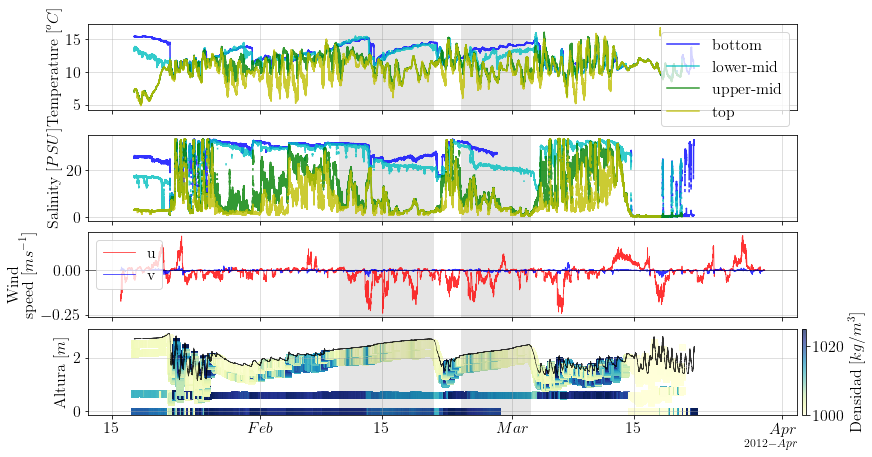

In [28]:
tmin = 8
tmax = 16
dmin = 1000
dmax = 1025
smin = 0
smax = 30

fig, (ax1, ax4, ax3, ax2) = plt.subplots(nrows=4, figsize=(12, 6), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico de profundidad y densidad (color map) DC
ax1.set_ylabel(r"Temperature "
          r"$\displaystyle[^oC]$",
          fontsize=16)
ax1.axvline(x=datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax1.axvline(x=datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax1.plot(DC_CTD.time, DC_CTD.sel(sensor=1, variables='Temperature').v, c='b', alpha=0.8, linewidth=1.5, label='bottom')
ax1.plot(DC_CTD.time, DC_CTD.sel(sensor=2, variables='Temperature').v, c='c', alpha=0.8, linewidth=1.5, label='lower-mid')
ax1.plot(DC_CTD.time, DC_CTD.sel(sensor=3, variables='Temperature').v, c='g', alpha=0.8, linewidth=1.5, label='upper-mid')
ax1.plot(DC_CTD.time, DC_CTD.sel(sensor=4, variables='Temperature').v, c='y', alpha=0.8, linewidth=1.5, label='top')

ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)
# ax1.text(pd.to_datetime('2012-3-30 00:00:00'), 2.5, 'A',
#           fontsize=16)
ax1.legend(loc='upper right',
          fontsize=16);

#Grafico de profundidad y densidad (color map) DC
ax2.set_ylabel(r"Altura "
          r"$\displaystyle[m]$",
          fontsize=16)
ax2.axvline(x=datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax2.axvline(x=datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax2.plot(DC_CTD.time, DC_CTD.sel(sensor=1, variables='Depth').v, c='k', alpha=0.8, linewidth=0.5)
scat = ax2.scatter(DC_CTD.time, DC_CTD.sel(sensor=1, variables='Depth2').v, c=DC_CTD.sel(sensor=1, variables='Density').v, marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=dmin, vmax=dmax)
ax2.scatter(DC_CTD.time, DC_CTD.sel(sensor=2, variables='Depth2').v, c=DC_CTD.sel(sensor=2, variables='Density').v, marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=dmin, vmax=dmax)
ax2.scatter(DC_CTD.time, DC_CTD.sel(sensor=3, variables='Depth2').v, c=DC_CTD.sel(sensor=3, variables='Density').v, marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=dmin, vmax=dmax)
ax2.scatter(DC_CTD.time, DC_CTD.sel(sensor=4, variables='Depth2').v, c=DC_CTD.sel(sensor=4, variables='Density').v, marker='s', alpha=0.7, cmap=cm.YlGnBu, vmin=dmin, vmax=dmax)
cbar2 = fig.colorbar(scat, ax=ax2, pad=0.007)
cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=16)
cbar2.ax.tick_params(labelsize=16)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)
# ax2.text(pd.to_datetime('2012-3-30 00:00:00'), 2.5, 'B',
#           fontsize=16)

ax3.axvline(x=datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax3.axvline(x=datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax3.set_ylabel(r"Wind\\speed "
          r"$\displaystyle[ms^{-1}]$",
          fontsize=16)
ax3.plot(wdf.index, wdf['u'].values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax3.plot(wdf.index, wdf['v'].values, color='b', alpha=0.8, linewidth=0.8, label='v')
ax3.legend(loc='upper left',
          fontsize=16);
ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)
# ax3.text(pd.to_datetime('2012-3-30 00:00:00'), 8.7, 'B',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), 9.4, 'dirección mar adentro',
#           fontsize=16)
# ax3.text(pd.to_datetime('2012-1-25 00:00:00'), -12.5, 'dirección tierra adentro',
#           fontsize=16)

#Grafico de profundidad y densidad (color map) DC
ax4.set_ylabel(r"Salinity "
          r"$\displaystyle[PSU]$",
          fontsize=16)
ax4.axvline(x=datetime(2012,2,15,12,30,0), color='k', linewidth=95, alpha=0.1)
ax4.axvline(x=datetime(2012,2,28,2,30,0), color='k', linewidth=70, alpha=0.1)
ax4.plot(DC_CTD.time, DC_CTD.sel(sensor=1, variables='Sal_del').v, c='b', alpha=0.8, linewidth=1.5)
ax4.plot(DC_CTD.time, DC_CTD.sel(sensor=2, variables='Sal_del').v, c='c', alpha=0.8, linewidth=1.5)
ax4.plot(DC_CTD.time, DC_CTD.sel(sensor=3, variables='Sal_del').v, c='g', alpha=0.8, linewidth=1.5)
ax4.plot(DC_CTD.time, DC_CTD.sel(sensor=4, variables='Sal_del').v, c='y', alpha=0.8, linewidth=1.5)


ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)
# ax4.text(pd.to_datetime('2012-3-30 00:00:00'), 2.5, 'B',
#           fontsize=16)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

# Temperatura

In [29]:
tdc1 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Temperature')
tdc2 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Temperature')
tdc3 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Temperature')
tdc4 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Temperature')

tnm1 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Temperature')
tnm2 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Temperature')
tnm3 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Temperature')

tml1 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Temperature')
tml2 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Temperature')

tpc1 = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Temperature')

wdf = dfw['u'].loc[datetime(2012,2,11):datetime(2012,2,22)]

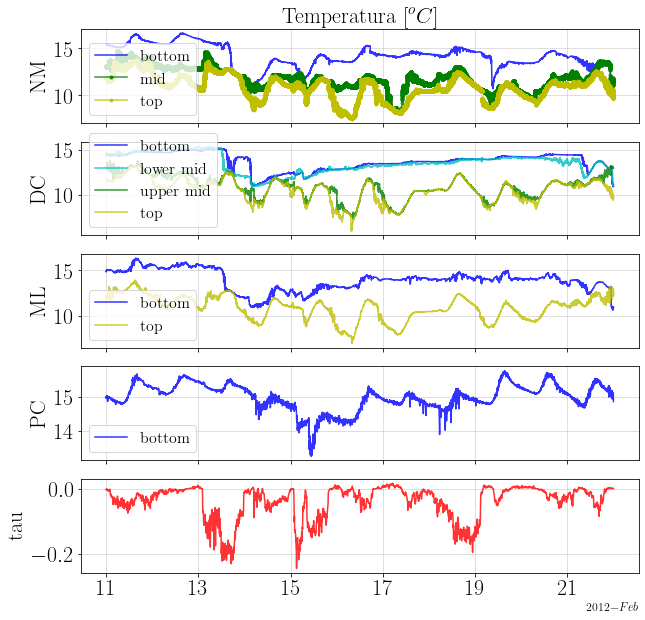

In [30]:
#Inicio figura
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(10, 10), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Temperatura "
          r"$\displaystyle[^o C]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.plot(tnm1.time, tnm1.v, c='b', alpha=0.8, label='bottom')
ax1.plot(tnm2.time, tnm2.v, marker="." , c='g', alpha=0.8, label='mid')
ax1.plot(tnm3.time, tnm3.v, marker="." , c='y', alpha=0.8, label='top')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.legend(loc='lower left',
          fontsize=16);

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.plot(tdc1.time, tdc1.v, c='b', alpha=0.8, label='bottom')
ax2.plot(tdc2.time, tdc2.v, c='c', alpha=0.8, label='lower mid')
ax2.plot(tdc3.time, tdc3.v, c='g', alpha=0.8, label='upper mid')
ax2.plot(tdc4.time, tdc4.v, c='y', alpha=0.8, label='top')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.legend(loc='lower left',
          fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.plot(tml1.time, tml1.v, c='b', alpha=0.8, label='bottom')
ax3.plot(tml2.time, tml2.v, c='y', alpha=0.8, label='top')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.legend(loc='lower left',
          fontsize=16);

ax4.set_ylabel(r"PC",
          fontsize=22)

ax4.plot(tpc1.time, tpc1.v, c='b', alpha=0.8, label='bottom')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.legend(loc='lower left',
          fontsize=16);

ax5.set_ylabel(r"tau",
          fontsize=22)

ax5.plot(wdf.index, wdf, c='r', alpha=0.8, label='bottom')
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

In [31]:
tdc1 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Temperature')
tdc2 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Temperature')
tdc3 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Temperature')
tdc4 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Temperature')

tnm1 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Temperature')
tnm2 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Temperature')
tnm3 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Temperature')

tml1 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Temperature')
tml2 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Temperature')

tpc1 = PC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Temperature')
wdf = dfw['u'].loc[datetime(2012,2,24):datetime(2012,3,3)]

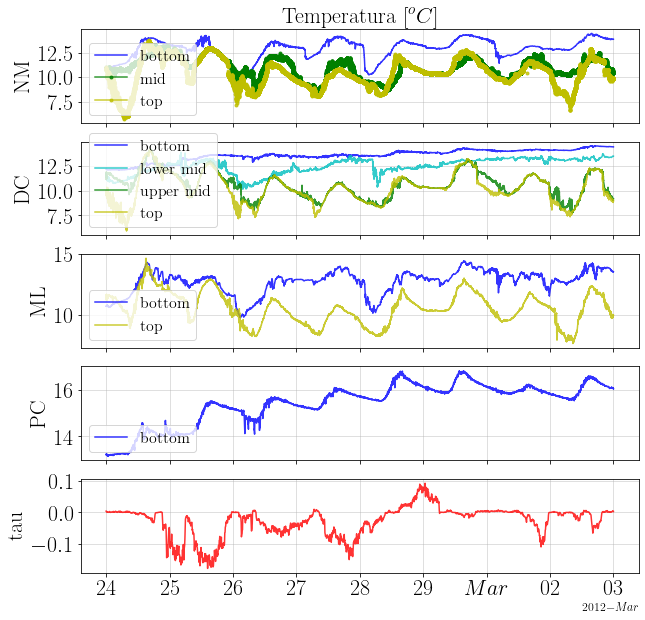

In [32]:
#Inicio figura
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(10, 10), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Temperatura "
          r"$\displaystyle[^o C]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.plot(tnm1.time, tnm1.v, c='b', alpha=0.8, label='bottom')
ax1.plot(tnm2.time, tnm2.v, marker="." , c='g', alpha=0.8, label='mid')
ax1.plot(tnm3.time, tnm3.v, marker="." , c='y', alpha=0.8, label='top')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.legend(loc='lower left',
          fontsize=16);

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.plot(tdc1.time, tdc1.v, c='b', alpha=0.8, label='bottom')
ax2.plot(tdc2.time, tdc2.v, c='c', alpha=0.8, label='lower mid')
ax2.plot(tdc3.time, tdc3.v, c='g', alpha=0.8, label='upper mid')
ax2.plot(tdc4.time, tdc4.v, c='y', alpha=0.8, label='top')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.legend(loc='lower left',
          fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.plot(tml1.time, tml1.v, c='b', alpha=0.8, label='bottom')
ax3.plot(tml2.time, tml2.v, c='y', alpha=0.8, label='top')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.legend(loc='lower left',
          fontsize=16);

ax4.set_ylabel(r"PC",
          fontsize=22)

ax4.plot(tpc1.time, tpc1.v, c='b', alpha=0.8, label='bottom')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.legend(loc='lower left',
          fontsize=16);

ax5.set_ylabel(r"tau",
          fontsize=22)

ax5.plot(wdf.index, wdf, c='r', alpha=0.8, label='bottom')
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

# Salinidad

In [33]:
tdc1 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Sal_del')
tdc2 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Sal_del')
tdc3 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Sal_del')
tdc4 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Sal_del')

tnm1 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Sal_del')
tnm2 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Sal_del')
tnm3 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Sal_del')

tml1 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Sal_del')
tml2 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Sal_del')

tpc1 = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Sal_del')

wdf = dfw['u'].loc[datetime(2012,2,11):datetime(2012,2,22)]

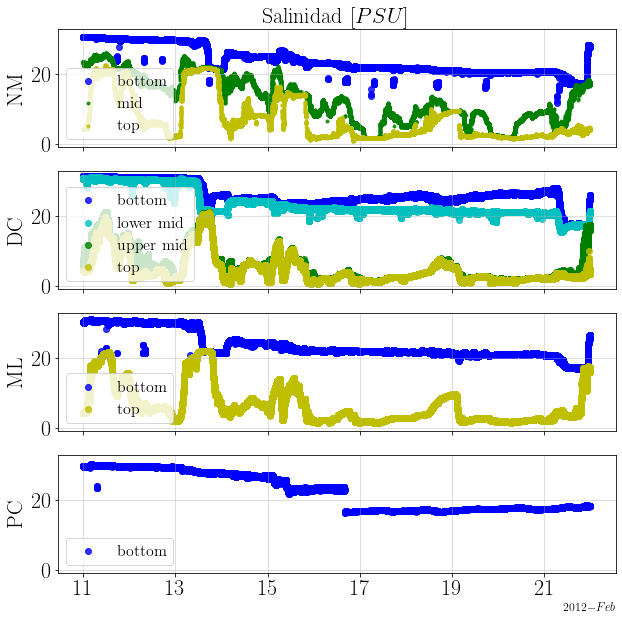

In [34]:
#Inicio figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 10), sharex=True, sharey=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Salinidad "
          r"$\displaystyle[PSU]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.scatter(tnm1.time, tnm1.v, c='b', alpha=0.8, label='bottom')
ax1.scatter(tnm2.time, tnm2.v, marker='.', c='g', alpha=0.8, label='mid')
ax1.scatter(tnm3.time, tnm3.v, marker='.', c='y', alpha=0.8, label='top')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.legend(loc='lower left',
          fontsize=16);

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.scatter(tdc1.time, tdc1.v, c='b', alpha=0.8, label='bottom')
ax2.scatter(tdc2.time, tdc2.v, c='c', alpha=0.8, label='lower mid')
ax2.scatter(tdc3.time, tdc3.v, c='g', alpha=0.8, label='upper mid')
ax2.scatter(tdc4.time, tdc4.v, c='y', alpha=0.8, label='top')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.legend(loc='lower left',
          fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.scatter(tml1.time, tml1.v, c='b', alpha=0.8, label='bottom')
ax3.scatter(tml2.time, tml2.v, c='y', alpha=0.8, label='top')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.legend(loc='lower left',
          fontsize=16);

ax4.set_ylabel(r"PC",
          fontsize=22)

ax4.scatter(tpc1.time, tpc1.v, c='b', alpha=0.8, label='bottom')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.legend(loc='lower left',
          fontsize=16);

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

In [35]:
min6_6 = pd.date_range(start=datetime(2012,2,12,12,0,0), end=datetime(2012,2,14,12,0,0), periods=None, freq='6min')

wdf = dfw['u'].loc[datetime(2012,2,12,12,0,0):datetime(2012,2,14,12,0,0)]

dc = DC_CTD.sel(time=min6_6).v
nm = NM_CTD.sel(time=min6_6).v
ml = ML_CTD.sel(time=min6_6).v
pc = PC_CTD.sel(time=min6_6).v

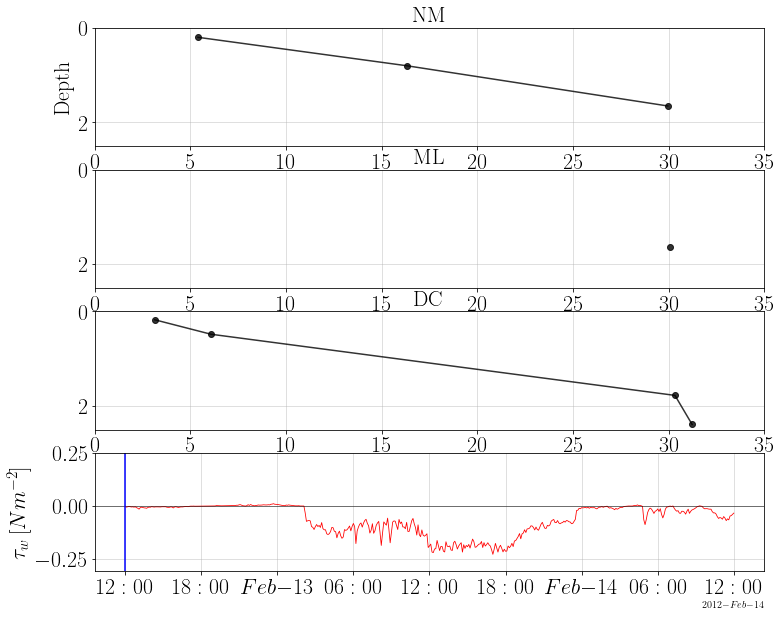

In [77]:
%matplotlib inline
x = 0
#Inicio figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 10))


#Perfil NM
ax1.set_title(r"NM",
          fontsize=22)
ax1.set_ylabel(r"Depth",
          fontsize=22)


ax1.plot(nm.sel(variables='Sal_del').isel(time=x), nm.sel(variables= 'Depth').isel(time=0), c='k', alpha=0.8, marker='o')

ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.set_ylim(0, 2.5)
ax1.set_xlim(0, 35)
ax1.invert_yaxis()

#Perfil ML
ax2.set_title(r"ML",
          fontsize=22)


ax2.plot(ml.sel(variables='Sal_del').isel(time=x), ml.sel(variables= 'Depth').isel(time=0), c='k', alpha=0.8, marker='o')

ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.invert_yaxis()
ax2.set_ylim(0, 2.5)
ax2.set_xlim(0, 35)
ax2.invert_yaxis()

# Perfil DC
ax3.set_title(r"DC",
          fontsize=22)


ax3.plot(dc.sel(variables='Sal_del').isel(time=x), dc.sel(variables= 'Depth').isel(time=0), c='k', alpha=0.8, marker='o')

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.invert_yaxis()
ax3.set_ylim(0, 2.5)
ax3.set_xlim(0, 35)
ax3.invert_yaxis()

#Grafico velocidad viento

ax4.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax4.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax4.axhline(y=0, color='k', linewidth=0.5)
ax4.axvline(x=min6_6[x], color='b')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_ylim(-0.31, 0.25)

# Ajustar formato fecha
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

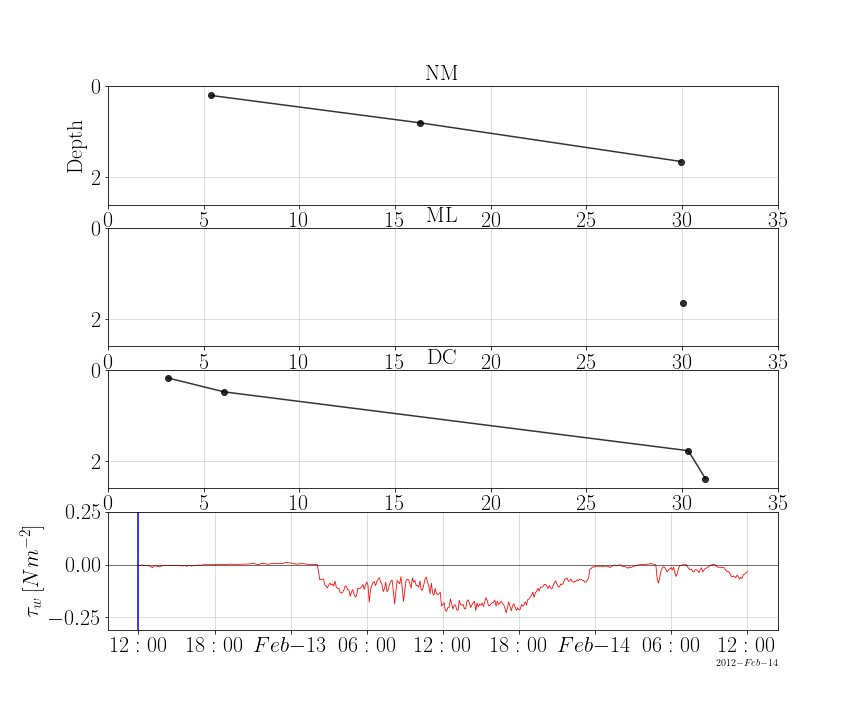

In [37]:
%matplotlib widget

#Inicio figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(12, 10))


#Perfil NM
ax1.set_title(r"NM",
          fontsize=22)
ax1.set_ylabel(r"Depth",
          fontsize=22)


nm_plt, = ax1.plot(nm.sel(variables='Sal_del').isel(time=0), nm.sel(variables= 'Depth').isel(time=0), c='k', alpha=0.8, marker='o')

ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.set_ylim(0, 2.6)
ax1.set_xlim(0, 35)
ax1.invert_yaxis()

#Perfil ML
ax2.set_title(r"ML",
          fontsize=22)


ml_plt, = ax2.plot(ml.sel(variables='Sal_del').isel(time=0), ml.sel(variables= 'Depth').isel(time=0), c='k', alpha=0.8, marker='o')

ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.invert_yaxis()
ax2.set_ylim(0, 2.6)
ax2.set_xlim(0, 35)
ax2.invert_yaxis()

# Perfil DC
ax3.set_title(r"DC",
          fontsize=22)


dc_plt, = ax3.plot(dc.sel(variables='Sal_del').isel(time=0), dc.sel(variables= 'Depth').isel(time=0), c='k', alpha=0.8, marker='o')

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.invert_yaxis()
ax3.set_ylim(0, 2.6)
ax3.set_xlim(0, 35)
ax3.invert_yaxis()

#Grafico velocidad viento

ax4.set_ylabel(r"$\tau_w\,[Nm^{-2}]$ ",
          fontsize=22)
ax4.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax4.axhline(y=0, color='k', linewidth=0.5)
line, = ax4.plot([min6_6[0], min6_6[0]], [-0.31, 0.25], color='b')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.set_ylim(-0.31, 0.25)

# Ajustar formato fecha
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

def animate(i):
    nm_plt.set_ydata(nm.sel(variables='Depth').isel(time=i))  # update the data.
    nm_plt.set_xdata(nm.sel(variables='Sal_del').isel(time=i))  # update the data.
    ml_plt.set_ydata(ml.sel(variables='Depth').isel(time=i))  # update the data.
    ml_plt.set_xdata(ml.sel(variables='Sal_del').isel(time=i))  # update the data.
    dc_plt.set_ydata(dc.sel(variables='Depth').isel(time=i))  # update the data.
    dc_plt.set_xdata(dc.sel(variables='Sal_del').isel(time=i))  # update the data.
    line.set_data( [min6_6[i], min6_6[i]], [-0.31, 0.25])  # update the data.
    return nm_plt, ml_plt, dc_plt, line,


ani = FuncAnimation(fig, animate, interval=40, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()


In [31]:
tdc1 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Sal_del')
tdc2 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Sal_del')
tdc3 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Sal_del')
tdc4 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Sal_del')

tnm1 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Sal_del')
tnm2 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Sal_del')
tnm3 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Sal_del')

tml1 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Sal_del')
tml2 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Sal_del')

tpc1 = PC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Sal_del')

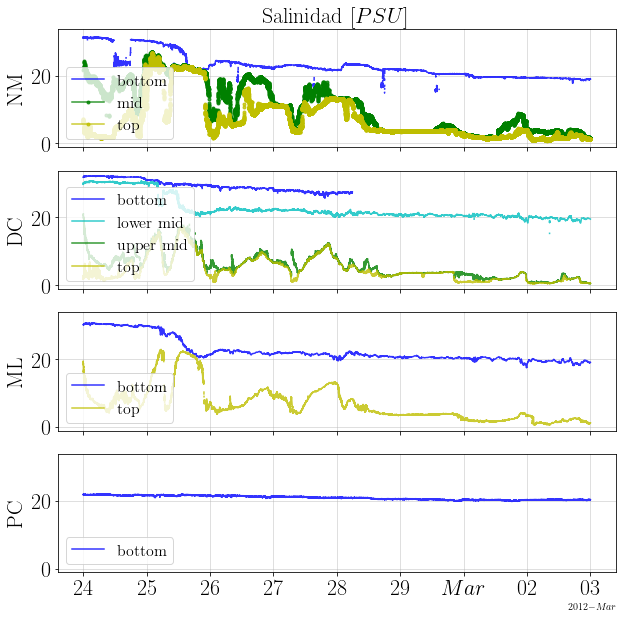

In [32]:
%matplotlib inline
#Inicio figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 10), sharex=True, sharey=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Salinidad "
          r"$\displaystyle[PSU]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.plot(tnm1.time, tnm1.v, c='b', alpha=0.8, label='bottom')
ax1.plot(tnm2.time, tnm2.v, marker="." , c='g', alpha=0.8, label='mid')
ax1.plot(tnm3.time, tnm3.v, marker="." , c='y', alpha=0.8, label='top')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.legend(loc='lower left',
          fontsize=16);

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.plot(tdc1.time, tdc1.v, c='b', alpha=0.8, label='bottom')
ax2.plot(tdc2.time, tdc2.v, c='c', alpha=0.8, label='lower mid')
ax2.plot(tdc3.time, tdc3.v, c='g', alpha=0.8, label='upper mid')
ax2.plot(tdc4.time, tdc4.v, c='y', alpha=0.8, label='top')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.legend(loc='lower left',
          fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.plot(tml1.time, tml1.v, c='b', alpha=0.8, label='bottom')
ax3.plot(tml2.time, tml2.v, c='y', alpha=0.8, label='top')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.legend(loc='lower left',
          fontsize=16);

ax4.set_ylabel(r"PC",
          fontsize=22)

ax4.plot(tpc1.time, tpc1.v, c='b', alpha=0.8, label='bottom')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.legend(loc='lower left',
          fontsize=16);

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

# Densidad

## Gráfico de líneas

In [50]:
tdc1 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density')
tdc2 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density')
tdc3 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density')
tdc4 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Density')

tnm1 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density')
tnm2 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density')
tnm3 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density')

tml1 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density')
tml2 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density')

tpc1 = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density')

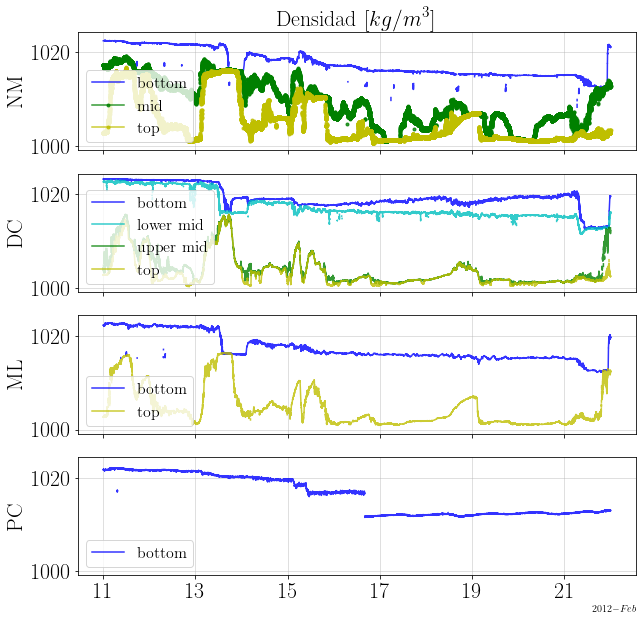

In [52]:
#Inicio figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 10), sharex=True, sharey=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.plot(tnm1.time, tnm1.v, c='b', alpha=0.8, label='bottom')
ax1.plot(tnm2.time, tnm2.v, marker=".", c='g', alpha=0.8, label='mid')
ax1.plot(tnm3.time, tnm3.v, marker=".", c='y', alpha=0.8, label='top')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.legend(loc='lower left',
          fontsize=16);

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.plot(tdc1.time, tdc1.v, c='b', alpha=0.8, label='bottom')
ax2.plot(tdc2.time, tdc2.v, c='c', alpha=0.8, label='lower mid')
ax2.plot(tdc3.time, tdc3.v, c='g', alpha=0.8, label='upper mid')
ax2.plot(tdc4.time, tdc4.v, c='y', alpha=0.8, label='top')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.legend(loc='lower left',
          fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.plot(tml1.time, tml1.v, c='b', alpha=0.8, label='bottom')
ax3.plot(tml2.time, tml2.v, c='y', alpha=0.8, label='top')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.legend(loc='lower left',
          fontsize=16);

ax4.set_ylabel(r"PC",
          fontsize=22)

ax4.plot(tpc1.time, tpc1.v, c='b', alpha=0.8, label='bottom')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.legend(loc='lower left',
          fontsize=16);

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

In [53]:
tdc1 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density')
tdc2 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density')
tdc3 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density')
tdc4 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Density')

tnm1 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density')
tnm2 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density')
tnm3 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density')

tml1 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density')
tml2 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density')

tpc1 = PC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density')

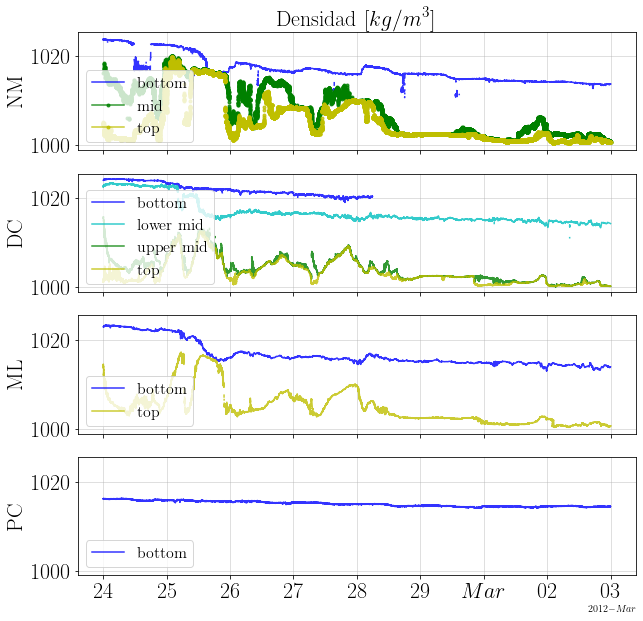

In [54]:
#Inicio figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(10, 10), sharex=True, sharey=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.plot(tnm1.time, tnm1.v, c='b', alpha=0.8, label='bottom')
ax1.plot(tnm2.time, tnm2.v, marker=".", c='g', alpha=0.8, label='mid')
ax1.plot(tnm3.time, tnm3.v, marker=".", c='y', alpha=0.8, label='top')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.legend(loc='lower left',
          fontsize=16);

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.plot(tdc1.time, tdc1.v, c='b', alpha=0.8, label='bottom')
ax2.plot(tdc2.time, tdc2.v, c='c', alpha=0.8, label='lower mid')
ax2.plot(tdc3.time, tdc3.v, c='g', alpha=0.8, label='upper mid')
ax2.plot(tdc4.time, tdc4.v, c='y', alpha=0.8, label='top')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.legend(loc='lower left',
          fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.plot(tml1.time, tml1.v, c='b', alpha=0.8, label='bottom')
ax3.plot(tml2.time, tml2.v, c='y', alpha=0.8, label='top')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.legend(loc='lower left',
          fontsize=16);

ax4.set_ylabel(r"PC",
          fontsize=22)

ax4.plot(tpc1.time, tpc1.v, c='b', alpha=0.8, label='bottom')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
ax4.legend(loc='lower left',
          fontsize=16);

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

## Gráfico de colores

In [40]:
tdc1 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density')
tdc2 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density')
tdc3 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density')
tdc4 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Density')

tnm1 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density')
tnm2 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density')
tnm3 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density')

tml1 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density')
tml2 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density')

tpc1 = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density')

In [56]:
ddc1 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Depth').v
ddc2 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Depth').v
ddc3 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Depth').v
ddc4 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Depth').v

dnm1 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Depth').v
dnm2 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Depth').v
dnm3 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Depth').v

dml1 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Depth').v
dml2 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Depth').v

dpc1 = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Depth').v

wdf = dfw['u'].loc[datetime(2012,2,11):datetime(2012,2,22)]

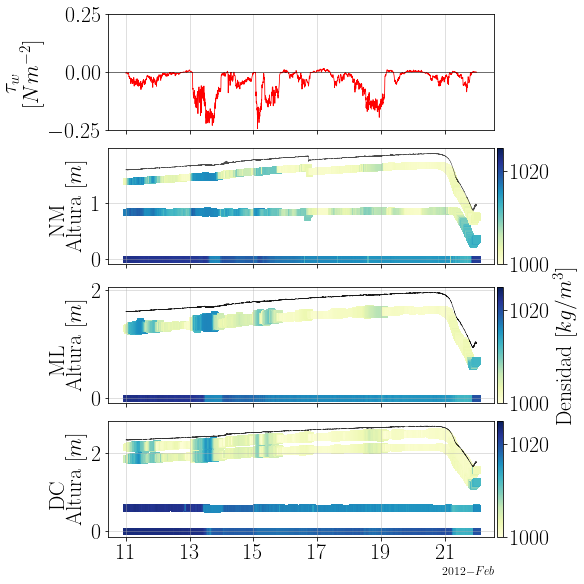

In [42]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax4, ax5, ax3) = plt.subplots(nrows=4, figsize=(8, 8), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
# contourf_ = ax1.contourf(bu2.time, y_bin,
#                          np.transpose(bu2.values),
#                          levels=level_boundaries_u,
#                          cmap=cm.RdBu_r,
#                          vmax=umax, vmin=umin, extend='both')
# cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
# cbar.ax.tick_params(labelsize=16)
# cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
# cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
# cbar.set_label("Velocity [$m/s$]", loc='center',
#           fontsize=16)
# ax1.set_ylabel(r"Depth "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax1.grid(alpha=0.5)
# ax1.set_ylim(1, 2.5)
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.plot(tdc1.time, ddc1, c='k', alpha=0.8, linewidth=0.5)
scat = ax3.scatter(tdc1.time, ddc1-ddc1, c=tdc1.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(tdc2.time, ddc1-ddc2, c=tdc2.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(tdc3.time, ddc1-ddc3, c=tdc3.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(tdc4.time, ddc1-ddc4, c=tdc4.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax4.plot(dnm1.time, dnm1, c='k', alpha=0.7, linewidth=0.5)
scat = ax4.scatter(dnm1.time, dnm1-dnm1, c=tnm1.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(dnm2.time, dnm1-dnm2, c=tnm2.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(dnm3.time, dnm1-dnm3, c=tnm3.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=22)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w$\\$[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.25, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=22)
ax5.plot(dml1.time, dml1, c='k', alpha=0.9, linewidth=0.5)
scat = ax5.scatter(dml1.time, dml1-dml1, c=tml1.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(dml2.time, dml1-dml2, c=tml2.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=22)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=22)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)


#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

In [43]:
tdc1 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density')
tdc2 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density')
tdc3 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density')
tdc4 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Density')

tnm1 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density')
tnm2 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density')
tnm3 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density')

tml1 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density')
tml2 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density')

tpc1 = PC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density')

In [44]:
ddc1 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Depth').__xarray_dataarray_variable__
ddc2 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Depth').__xarray_dataarray_variable__
ddc3 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Depth').__xarray_dataarray_variable__
ddc4 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Depth').__xarray_dataarray_variable__

dnm1 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Depth').__xarray_dataarray_variable__
dnm2 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Depth').__xarray_dataarray_variable__
dnm3 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Depth').__xarray_dataarray_variable__

dml1 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Depth').__xarray_dataarray_variable__
dml2 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Depth').__xarray_dataarray_variable__

dpc1 = PC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Depth').__xarray_dataarray_variable__

wdf = dfw['u'].loc[datetime.date(2012,2,24):datetime.date(2012,3,3)]

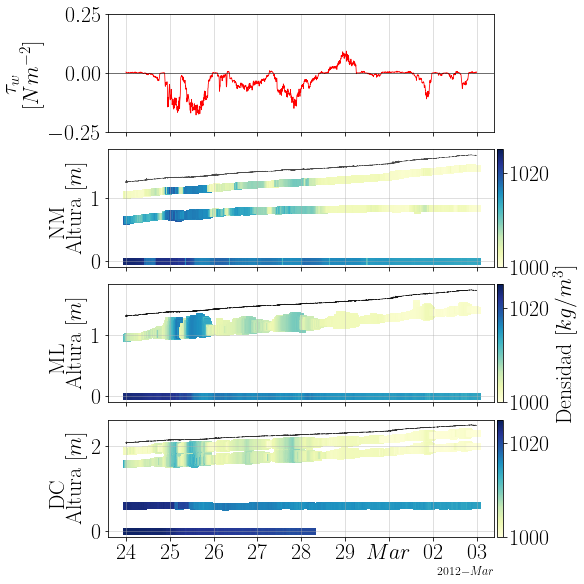

In [45]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax4, ax5, ax3) = plt.subplots(nrows=4, figsize=(8, 8), constrained_layout=True, sharex=True)

# fig = plt.figure(figsize=(10, 24), constrained_layout=True)
# gs = GridSpec(14, 1, figure=fig)

#Grafico de velocidad del agua (color map)
# ax1 = fig.add_subplot(gs[:3, 0])
# ax1.set_title(r"Velocity from ADCP $[ms^{-1}]$",
#           fontsize=16)
# contourf_ = ax1.contourf(bu2.time, y_bin,
#                          np.transpose(bu2.values),
#                          levels=level_boundaries_u,
#                          cmap=cm.RdBu_r,
#                          vmax=umax, vmin=umin, extend='both')
# cbar = fig.colorbar(contourf_, ax=ax1, pad=0.007)
# cbar.ax.tick_params(labelsize=16)
# cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
# cbar.ax.yaxis.set_major_locator(tick.MultipleLocator(0.04))
# cbar.set_label("Velocity [$m/s$]", loc='center',
#           fontsize=16)
# ax1.set_ylabel(r"Depth "
#           r"$\displaystyle[m]$",
#           fontsize=16)
# ax1.grid(alpha=0.5)
# ax1.set_ylim(1, 2.5)
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.yaxis.set_tick_params(labelsize=16)



#Grafico de profundidad y densidad (color map) DC
# ax3 = fig.add_subplot(gs[6, 0])
# ax3.set_title(r"Density calculated from temperature and salinity at DC [$kg/m^3$]",
#           fontsize=16)
ax3.set_ylabel(r"DC \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax3.plot(tdc1.time, ddc1, c='k', alpha=0.8, linewidth=0.5)
scat = ax3.scatter(tdc1.time, ddc1-ddc1, c=tdc1.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(tdc2.time, ddc1-ddc2, c=tdc2.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(tdc3.time, ddc1-ddc3, c=tdc3.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax3.scatter(tdc4.time, ddc1-ddc4, c=tdc4.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar2 = fig.colorbar(scat, ax=ax3, pad=0.007)
cbar2.ax.tick_params(labelsize=22)
# cbar2.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)

# Grafico densidades NM
# ax4 = fig.add_subplot(gs[4, 0])
# ax4.set_title(r"Density calculated from temperature and salinity at NM [$kg/m^3$]",
#           fontsize=16)
ax4.set_ylabel(r"NM \\ Altura "
          r"$\displaystyle[m]$",
          fontsize=22)
ax4.plot(dnm1.time, dnm1, c='k', alpha=0.7, linewidth=0.5)
scat = ax4.scatter(dnm1.time, dnm1-dnm1, c=tnm1.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(dnm2.time, dnm1-dnm2, c=tnm2.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax4.scatter(dnm3.time, dnm1-dnm3, c=tnm3.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar3 = fig.colorbar(scat, ax=ax4, pad=0.007)
cbar3.ax.tick_params(labelsize=22)
# cbar3.set_label("Densidad [$kg/m^3$]", loc='center',
#           fontsize=16)
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)

#Grafico velocidad viento
# ax2 = fig.add_subplot(gs[3, 0])
# ax2.set_title(r"Meteorogical station",
#           fontsize=16)
ax2.set_ylabel(r"$\tau_w$\\$[Nm^{-2}]$ ",
          fontsize=22)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.set_ylim(-0.25, 0.25)

# Grafico densidades ML
# ax5 = fig.add_subplot(gs[5, 0])
# ax5.set_title(r"Density calculated from temperature and salinity at ML [$kg/m^3$]",
#           fontsize=16)
ax5.set_ylabel(r"ML \\ Altura $[m]$",
          fontsize=22)
ax5.plot(dml1.time, dml1, c='k', alpha=0.9, linewidth=0.5)
scat = ax5.scatter(dml1.time, dml1-dml1, c=tml1.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
ax5.scatter(dml2.time, dml1-dml2, c=tml2.__xarray_dataarray_variable__, marker='s', cmap=cm.YlGnBu, vmin=1000, vmax=1025)
cbar4 = fig.colorbar(scat, ax=ax5, pad=0.007)
cbar4.ax.tick_params(labelsize=22)
cbar4.set_label("Densidad [$kg/m^3$]", loc='center',
          fontsize=22)
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)


#Ajustar limites colorbar
umin = -0.04
umax = 0.04
vmin = -0.04
vmax = 0.04
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)




# Ajustar formato fecha

ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(formatter)

plt.show() 

## Cambios de densidad en la vertical

In [70]:
tdc12 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density') - DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density')
tdc23 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density') - DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density')
tdc34 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density') - DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Density')
tdc14 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density') - DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Density')

tnm12 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density') - NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density')
tnm23 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density') - NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density')
tnm13 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density') - NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density')

tml12 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density') - ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density')


In [71]:
ddc12 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Depth').v - DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Depth').v
ddc23 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Depth').v - DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Depth').v
ddc34 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Depth').v - DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Depth').v
ddc14 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Depth').v - DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Depth').v

dnm12 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Depth').v - NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Depth').v
dnm23 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Depth').v - NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Depth').v
dnm13 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Depth').v - NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Depth').v

dml12 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Depth').v - ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Depth').v

wdf = dfw['u'].loc[datetime(2012,2,11):datetime(2012,2,22)]

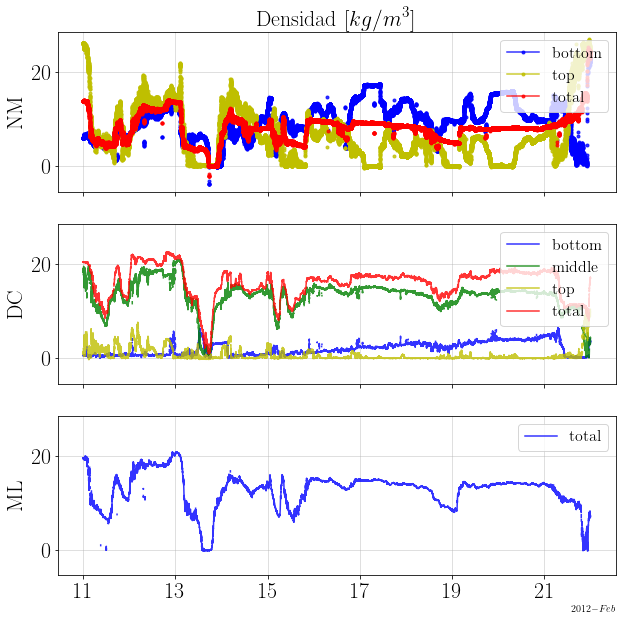

In [72]:
#Inicio figura
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 10), sharex=True, sharey=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.plot(tnm12.time, tnm12.v/dnm12, marker=".", c='b', alpha=0.8, label='bottom')
ax1.plot(tnm23.time, tnm23.v/dnm23, marker=".", c='y', alpha=0.8, label='top')
ax1.plot(tnm13.time, tnm13.v/dnm13, marker=".", c='r', alpha=0.8, label='total')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.legend(loc='upper right',
          fontsize=16);

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.plot(tdc12.time, tdc12.v, c='b', alpha=0.8, label='bottom')
ax2.plot(tdc23.time, tdc23.v, c='g', alpha=0.8, label='middle')
ax2.plot(tdc34.time, tdc34.v, c='y', alpha=0.8, label='top')
ax2.plot(tdc14.time, tdc14.v, c='r', alpha=0.8, label='total')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.legend(loc='upper right',
          fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.plot(tml12.time, tml12.v, c='b', alpha=0.8, label='total')

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.legend(loc='upper right',
          fontsize=16);


ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

In [66]:
tdc12 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density') - DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density')
tdc23 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density') - DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density')
tdc34 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density') - DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Density')
tdc14 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density') - DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Density')

tnm12 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density') - NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density')
tnm23 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density') - NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density')
tnm13 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density') - NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density')

tml12 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density') - ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density')


In [67]:
ddc12 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Depth').v - DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Depth').v
ddc23 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Depth').v - DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Depth').v
ddc34 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Depth').v - DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Depth').v
ddc14 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Depth').v - DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Depth').v

dnm12 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Depth').v - NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Depth').v
dnm23 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Depth').v - NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Depth').v
dnm13 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Depth').v - NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Depth').v

dml12 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Depth').v - ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Depth').v

wdf = dfw['u'].loc[datetime(2012,2,11):datetime(2012,2,22)]

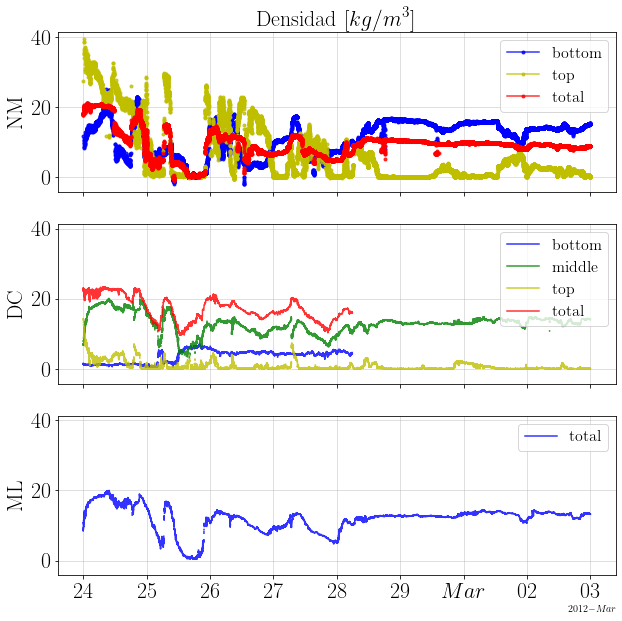

In [69]:
#Inicio figura
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 10), sharex=True, sharey=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.plot(tnm12.time, tnm12.v/dnm12, marker=".", c='b', alpha=0.8, label='bottom')
ax1.plot(tnm23.time, tnm23.v/dnm23, marker=".", c='y', alpha=0.8, label='top')
ax1.plot(tnm13.time, tnm13.v/dnm13, marker=".", c='r', alpha=0.8, label='total')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
ax1.legend(loc='upper right',
          fontsize=16);

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.plot(tdc12.time, tdc12.v, c='b', alpha=0.8, label='bottom')
ax2.plot(tdc23.time, tdc23.v, c='g', alpha=0.8, label='middle')
ax2.plot(tdc34.time, tdc34.v, c='y', alpha=0.8, label='top')
ax2.plot(tdc14.time, tdc14.v, c='r', alpha=0.8, label='total')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
ax2.legend(loc='upper right',
          fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.plot(tml12.time, tml12.v, c='b', alpha=0.8, label='total')

ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
ax3.legend(loc='upper right',
          fontsize=16);


ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

## Cambios de la densidad along-estuary

__Locations__

                  [37.264861111, -122.410527778], #ML

                  [37.264055556, -122.410333333], #DC

                  [37.265888889, -122.411027778], #NM
                  
                  [37.264111111, -122.406000000]])  #PC

In [77]:
x_nm_dc = haversine(37.265888889, -122.411027778, 37.264055556, -122.410333333)
rho_dcnm = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density') - DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Density')
wdf = dfw['u'].loc[datetime(2012,2,11):datetime(2012,2,22)]

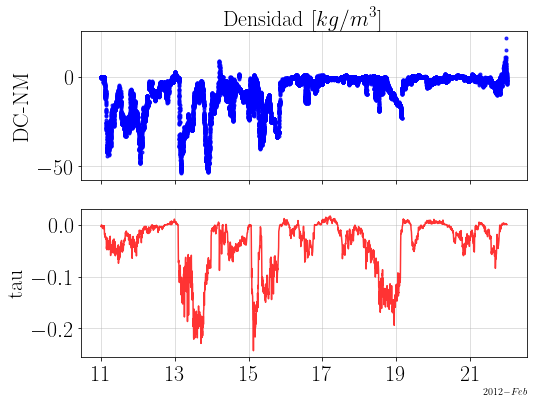

In [82]:
#Inicio figura
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax1.set_ylabel(r"DC-NM",
          fontsize=22)

ax1.plot(rho_dcnm.time, -rho_dcnm.v/x_nm_dc, marker=".", c='b', alpha=0.8, label='bottom')

ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)

ax2.set_ylabel(r"tau",
          fontsize=22)

ax2.plot(wdf.index, wdf, c='r', alpha=0.8, label='bottom')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

# Low-pass filter

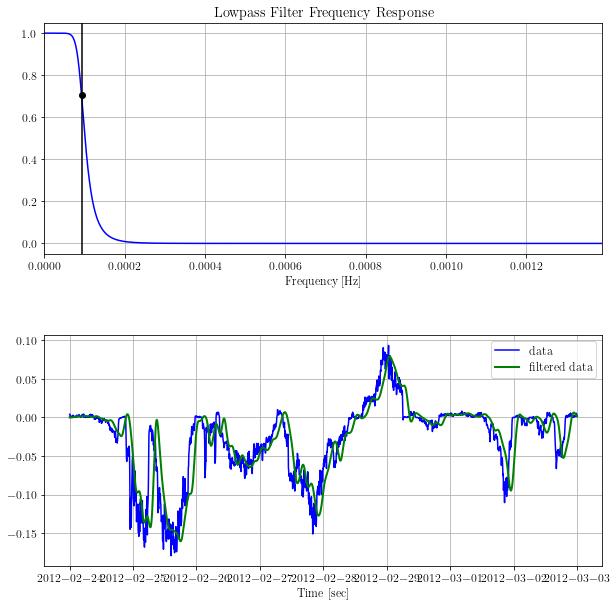

In [46]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 1/360       # sample rate, Hz
cutoff = 1/10800  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, fs=fs, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0         # seconds
n = int(T * fs) # total number of samples
t = wdf.index
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = wdf.values

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

In [54]:
tdc1 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tdc2 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tdc3 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tdc4 = DC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=4, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000

tnm1 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tnm2 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tnm3 = NM_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=3, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000

tml1 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tml2 = ML_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=2, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000

tpc1 = PC_CTD.sel(time=slice("2012-02-11 00:00:00","2012-02-22 00:00:00"), sensor=1, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000

wdf = dfw['u'].loc[datetime.date(2012,2,11):datetime.date(2012,2,22)]

In [55]:
# Filter requirements.
order = 6
cutoff = 1/10800  # desired cutoff frequency of the filter, Hz

# Filtrado de datos
fdc1 = butter_lowpass_filter(tdc1.values, cutoff, fs=0.1, order=6)
fdc2 = butter_lowpass_filter(tdc2.values, cutoff, fs=0.1, order=6)
fdc3 = butter_lowpass_filter(tdc3.values, cutoff, fs=0.1, order=6)
fdc4 = butter_lowpass_filter(tdc4.values, cutoff, fs=0.1, order=6)

fnm1 = butter_lowpass_filter(tnm1.values, cutoff, fs=0.1, order=6)
fnm2 = butter_lowpass_filter(tnm2.values, cutoff, fs=0.1, order=6)
fnm3 = butter_lowpass_filter(tnm3.values, cutoff, fs=0.1, order=6)

fml1 = butter_lowpass_filter(tml1.values, cutoff, fs=0.1, order=6)
fml2 = butter_lowpass_filter(tml2.values, cutoff, fs=0.1, order=6)

fpc1 = butter_lowpass_filter(tpc1.values, cutoff, fs=1/30, order=6)

fwdf = butter_lowpass_filter(wdf.values, cutoff, fs=1/360, order=6)

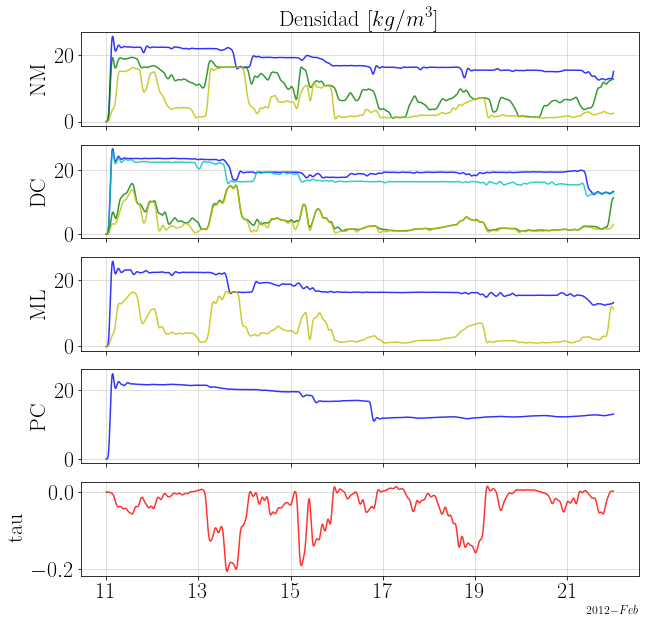

In [56]:
#Inicio figura
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(10, 10), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.plot(tnm1.time, fnm1, c='b', alpha=0.8, label='bottom')
ax1.plot(tnm2.time, fnm2, c='g', alpha=0.8, label='mid')
ax1.plot(tnm3.time, fnm3, c='y', alpha=0.8, label='top')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
# ax1.legend(loc='lower left',
#           fontsize=16);
# ax1.set_ylim(1000,1050)

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.plot(tdc1.time, fdc1, c='b', alpha=0.8, label='bottom')
ax2.plot(tdc2.time, fdc2, c='c', alpha=0.8, label='lower mid')
ax2.plot(tdc3.time, fdc3, c='g', alpha=0.8, label='upper mid')
ax2.plot(tdc4.time, fdc4, c='y', alpha=0.8, label='top')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
# ax2.legend(loc='lower left',
#           fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.plot(tml1.time, fml1, c='b', alpha=0.8, label='bottom')
ax3.plot(tml2.time, fml2, c='y', alpha=0.8, label='top')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
# ax3.legend(loc='lower left',
#           fontsize=16);

ax4.set_ylabel(r"PC",
          fontsize=22)

ax4.plot(tpc1.time, fpc1, c='b', alpha=0.8, label='bottom')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
# ax4.legend(loc='lower left',
#           fontsize=16);

ax5.set_ylabel(r"tau",
          fontsize=22)

ax5.plot(wdf.index, fwdf, c='r', alpha=0.8, label='bottom')
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

In [63]:
tdc1 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tdc2 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tdc3 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tdc4 = DC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=4, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000

tnm1 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tnm2 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tnm3 = NM_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=3, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000

tml1 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000
tml2 = ML_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=2, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000

tpc1 = PC_CTD.sel(time=slice("2012-02-24 00:00:00","2012-03-3 00:00:00"), sensor=1, variables='Density').__xarray_dataarray_variable__.interpolate_na(dim="time", method="nearest") -1000

wdf = dfw['u'].loc[datetime.date(2012,2,24):datetime.date(2012,3,3)]

In [51]:
# Filter requirements.
order = 6
cutoff = 1/10800  # desired cutoff frequency of the filter, Hz

# Filtrado de datos
fdc1 = butter_lowpass_filter(tdc1.values, cutoff, fs=0.1, order=6)
fdc2 = butter_lowpass_filter(tdc2.values, cutoff, fs=0.1, order=6)
fdc3 = butter_lowpass_filter(tdc3.values, cutoff, fs=0.1, order=6)
fdc4 = butter_lowpass_filter(tdc4.values, cutoff, fs=0.1, order=6)

fnm1 = butter_lowpass_filter(tnm1.values, cutoff, fs=0.1, order=6)
fnm2 = butter_lowpass_filter(tnm2.values, cutoff, fs=0.1, order=6)
fnm3 = butter_lowpass_filter(tnm3.values, cutoff, fs=0.1, order=6)

fml1 = butter_lowpass_filter(tml1.values, cutoff, fs=0.1, order=6)
fml2 = butter_lowpass_filter(tml2.values, cutoff, fs=0.1, order=6)

fpc1 = butter_lowpass_filter(tpc1.values, cutoff, fs=1/30, order=6)

fwdf = butter_lowpass_filter(wdf.values, cutoff, fs=1/360, order=6)

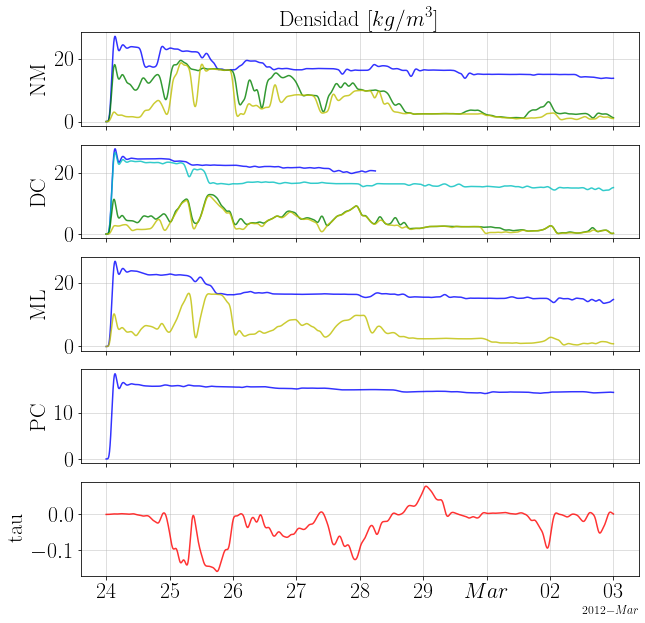

In [53]:
#Inicio figura
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(10, 10), sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Gráfico Temperatura
ax1.set_title(r"Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=22)
ax1.set_ylabel(r"NM",
          fontsize=22)

ax1.plot(tnm1.time, fnm1, c='b', alpha=0.8, label='bottom')
ax1.plot(tnm2.time, fnm2, c='g', alpha=0.8, label='mid')
ax1.plot(tnm3.time, fnm3, c='y', alpha=0.8, label='top')
ax1.xaxis.set_tick_params(labelsize=22)
ax1.yaxis.set_tick_params(labelsize=22)
ax1.grid(alpha=0.5)
# ax1.legend(loc='lower left',
#           fontsize=16);
# ax1.set_ylim(1000,1050)

ax2.set_ylabel(r"DC",
          fontsize=22)

ax2.plot(tdc1.time, fdc1, c='b', alpha=0.8, label='bottom')
ax2.plot(tdc2.time, fdc2, c='c', alpha=0.8, label='lower mid')
ax2.plot(tdc3.time, fdc3, c='g', alpha=0.8, label='upper mid')
ax2.plot(tdc4.time, fdc4, c='y', alpha=0.8, label='top')
ax2.xaxis.set_tick_params(labelsize=22)
ax2.yaxis.set_tick_params(labelsize=22)
ax2.grid(alpha=0.5)
# ax2.legend(loc='lower left',
#           fontsize=16);

ax3.set_ylabel(r"ML",
          fontsize=22)

ax3.plot(tml1.time, fml1, c='b', alpha=0.8, label='bottom')
ax3.plot(tml2.time, fml2, c='y', alpha=0.8, label='top')
ax3.xaxis.set_tick_params(labelsize=22)
ax3.yaxis.set_tick_params(labelsize=22)
ax3.grid(alpha=0.5)
# ax3.legend(loc='lower left',
#           fontsize=16);

ax4.set_ylabel(r"PC",
          fontsize=22)

ax4.plot(tpc1.time, fpc1, c='b', alpha=0.8, label='bottom')
ax4.xaxis.set_tick_params(labelsize=22)
ax4.yaxis.set_tick_params(labelsize=22)
ax4.grid(alpha=0.5)
# ax4.legend(loc='lower left',
#           fontsize=16);

ax5.set_ylabel(r"tau",
          fontsize=22)

ax5.plot(wdf.index, fwdf, c='r', alpha=0.8, label='bottom')
ax5.xaxis.set_tick_params(labelsize=22)
ax5.yaxis.set_tick_params(labelsize=22)
ax5.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)